<a href="https://colab.research.google.com/github/alechain/bert_classification_new/blob/main/model_bert_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import re
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import zipfile
from io import BytesIO
import requests
from pathlib import Path

# Cargamos la base de datos

In [2]:

# URL del dataset en Github
zip_file_url = 'https://github.com/alechain/bert_classification_new/raw/main/articles_df_final.parquet.zip'

# Descargamos el ZIP
response = requests.get(zip_file_url)

# chequeamos si se descargo bien (status code 200)
if response.status_code == 200:
    # Read the content of the zip file
    with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_file:
        # Assume there's only one file in the zip, you may need to modify accordingly
        file_name = zip_file.namelist()[0]

        # Read the parquet file using pandas
        with zip_file.open(file_name) as parquet_file:
            my_dataset = pd.read_parquet(BytesIO(parquet_file.read()))
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


In [3]:
#Filtramos posibles errores en articulos con longitud muy pequeña:
my_dataset=my_dataset[[len(i)>=200 for i in my_dataset.sentence]].reset_index(drop=True)

# EDA de la base de datos

In [119]:
my_dataset.head(5)

label                                           sentence        date
0   eco  > El Ministerio de Economía creó el Programa d...  2023-01-19
1   eco  > Los bonos soberanos en moneda extranjera reg...  2022-07-02
2   eco  > El presidente Alberto Fernández, destacó que...  2022-08-11
3   eco  > El Ente Nacional Regulador de la Electricida...  2022-09-10
4   eco  > El Banco Central arrancó la semana comprando...  2023-05-23

In [120]:
print(f'Cantidad de articulos totales: {my_dataset.sentence.count()}')

Cantidad de articulos totales: 21057


In [121]:
print(f'Fecha mínima de artículo: {my_dataset.date.min()}\nFecha máxima de artículo: {my_dataset.date.max()}')

Fecha mínima de artículo: 2021-08-24
Fecha máxima de artículo: 2023-10-06


In [122]:
print(f'Cantidad de Artículos por Clase:\n',my_dataset.groupby('label')['sentence'].count())

Cantidad de Artículos por Clase:
 label
eco       5234
el-mun    5239
el-pai    5184
socie     5400
Name: sentence, dtype: int64


In [123]:
length_text=np.array([len(i) for i in my_dataset.sentence])
print(f'Longitud del texto media de los artículos: {np.round(length_text.mean(),0)} Palabras')

Longitud del texto media de los artículos: 4069.0 Palabras


In [124]:
length_text=np.array([len(i) for i in my_dataset.sentence])
print(f'Longitud máxima de los artículos: {np.round(length_text.max(),0)} Palabras')

Longitud máxima de los artículos: 87059 Palabras


In [125]:
length_text=np.array([len(i) for i in my_dataset.sentence])
print(f'Longitud mínima de los artículos: {np.round(length_text.min(),0)} Palabras')

Longitud mínima de los artículos: 212 Palabras


# Fine tunning del modelo BERT

In [4]:

import torch
from transformers import BertTokenizer

In [5]:
# Chequeamos si hay GPU disponible (recomendable correr en un Kaggle notebook con device GPU100 16gb)
is_gpu = torch.cuda.is_available()
if is_gpu:
    # Decile a PyTorch que use la GPU.
    device = torch.device("cuda")
    print(f'\nHay {torch.cuda.device_count()} GPU(s) disponible(s).')
    print(f'Vamos a usar la GPU: {torch.cuda.get_device_name(0)}.\n')
# si no hay GPU...
else:
    print('\nNo hay GPU disponible, vamos a usar la CPU.\n')
    device = torch.device("cpu")


No hay GPU disponible, vamos a usar la CPU.



In [4]:
# Cargamos el tokenizador del modelo BERT en español (pre-trained)

In [75]:

BERT_MODEL = 'Recognai/bert-base-spanish-wwm-cased-xnli'
print('Cargando tokenizador de BERT...')
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
print('\nTokenizador de BERT listo.')

In [ ]:
# Re-ordenamos el dataset de manera random (sin estructura temporal) y sacamos una porcion para validación (5%)

In [6]:
val=0.05
seed=30

In [7]:
val_dataset=my_dataset.iloc[np.random.permutation(len(my_dataset))].sample(frac=val,random_state=seed)


In [8]:
my_dataset=my_dataset[~my_dataset.index.isin(val_dataset.index)].reset_index(drop=True)

In [9]:
val_dataset=val_dataset.reset_index(drop=True)

In [132]:
print(f'Cantidad de Artículos por Clase en Validation:\n',val_dataset.label.value_counts())

Cantidad de Artículos por Clase en Validation:
 label
socie     290
eco       265
el-mun    254
el-pai    244
Name: count, dtype: int64


Ahora definimos los parámetros para el tokenizador y para la cantidad de capas que vamos a hacer el fine tunning. En este caso solo vamos a usar los primeros 512 Tokens de cada noticia, estaremos perdiendo un poco de información (considerando el largo de los articulos) pero si el modelo logra un buen nivel de generalización debería poder clasificar un articulo con las primeras palabras de una noticia, sin necesidad de verla completamente.

En este caso vamos a hacer el fine tunning de la última capa del encoding del modelo BERT (pre-trained) y de la última capa del clasificador.

Vamos a entrenar con el 80% de la base, y validar con el restante 20%. Esto representa el 76% (.80*.95) de los artículos originales para train y el 19% (.20*.95) de los artículos originales para Test si consideramos el 5% original que se uso para validar.

La cantidad de epochs depende de el tamaño de la base, se recomienda entre 2 a 4 epochs cada 1000 ejemplos de entrenamiento. Como la base tiene aproximadamente 20.000 artículos y es una cantidad muy extensa, para evitar el overfitting vamos a trabajar con solo 20 epochs.

In [8]:

MY_DATASET_MAX_TOKENS = 512
if MY_DATASET_MAX_TOKENS>512:
  raise ValueError(f"ERROR: BERT no puede codificar frases con mas de 512 tokens, pero MY_DATASET_MAX_TOKENS = {MY_DATASET_MAX_TOKENS}.")


LAYERS_TO_FINETUNE=2
if LAYERS_TO_FINETUNE<1 or LAYERS_TO_FINETUNE>13:
  raise ValueError("LAYERS_TO_FINETUNE no puede ser menor a 1 o mayor a 13, poque BERT tiene 12 capas de encoder + 1 de clasificacion.")

# Que porcentaje del dataset vamos a usar para entrenar ?
TRAIN_FOR_PCT = 0.8
TRAIN_FOLD_SIZE = int(TRAIN_FOR_PCT * len(my_dataset))

# Number of training epochs. The BERT authors recommend between 2 and 4
# for over 1000 examples.
# We chose to run for 4, but this may be over-fitting the
# training data.
EPOCHS = 20

En esta parte pre-procesamos el input para que pueda ser consumido por los pipelines de pytorch en forma de tensores para el fine-tunning de BERT.

In [9]:
# Crear las listas de frases labels numéricosx
sentences = my_dataset.sentence.values
# labels en BERT DEBEN SER enteros; aqui transformos los valores de los labels
# a ints (mismo int, mismo valor), comenzando por 0.
labels, label_texts = pd.factorize(my_dataset.label)

# reordenar filas del dataset al azar; importante para el descenso de gradiente estocastico
my_dataset = my_dataset.iloc[np.random.permutation(len(my_dataset))]
my_dataset.reset_index(drop=True)

# MI_DATASET_NUM_LABELS es la cantidad de categorias distintas en su columna 'label'.
MY_DATASET_NUM_LABELS = labels.max() + 1

Aca utilizamos la funcion de encode_plus para pre-procesar los artículos, en esta parte se van a truncar al max_length definido de 512 tokens y se van a agregar las máscaras para indicar que es un clasificador (CLS) y en donde terminan las frases con SEP.

In [11]:
# codificar frases en su dataset
input_ids = []
attention_masks = []

# Por cada frase ...
for sent in sentences:
    # `encode_plus` va a :
    #   (1) Tokenizar la frase.
    #   (2) Poner el token `[CLS]` al comienzo de la frase.
    #   (3) Poner el token `[SEP]` al final de la frase.
    #   (4) Mapear tokens a sus IDs.
    #   (5) Rellenar o truncar la frase a `max_length`
    #   (6) Crear attention masks para los tokens [PAD].
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # frase a codificar.
                        add_special_tokens = True, # Agregar '[CLS]' y '[SEP]'
                        max_length = MY_DATASET_MAX_TOKENS,  # Rellenar frases cortas, truncar largas
                        padding='max_length',
                        truncation=True,
                        return_token_type_ids=True,
                        return_attention_mask = True,   # Construir attn. masks  (diferencian padding de non-padding).
                        return_tensors = 'pt',     # retornar los vectores de pytorchxs.
                   )

    # Agregar la frase codificada a la lista de frases
    input_ids.append(encoded_dict['input_ids'])

    # Agregar su correspondiente attention mask
    attention_masks.append(encoded_dict['attention_mask'])

# Convertiar las listas a tensores de Pytorch
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [12]:
## este es para ver la frase
tokenizer.decode(tokenizer.encode_plus( sentences[0],
                        sent,                      # frase a codificar.
                        add_special_tokens = True, # Agregar '[CLS]' y '[SEP]'
                        max_length = MY_DATASET_MAX_TOKENS,  # Rellenar frases cortas, truncar largas
                        padding='max_length',
                        truncation=True)['input_ids'])

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


'[CLS] [UNK] El Banco Central compró este jueves 9 millones de dólares en el mercado de cambios, con lo que registró 23 jornadas consecutivas con resultado positivo. La autoridad monetaria, al mismo tiempo, no modificó la tasa de interés en pesos, luego de los datos de inflación de agosto, cuando se anotó un alza del 12, 4 por ciento de aumentos en los precios minoristas. El dólar blue registró un retroceso de 10 pesos a [UNK] pesos por unidad. " En septiembre, el Banco Central acumula compras por 350 millones de dólares y totaliza desde el 24 de julio más de 2. 500 millones ", según detalló Gustavo Quintana, analista de PR Corredores de Cambio. En lo referido al tipo de cambio, el dólar minorista cerró a 365, 50 pesos. En el segmento bursátil, el dólar contado con liquidación ( CCL ) bajó 0, 2 por ciento, a [UNK], 25 pesos [UNK] mientras que el MEP subió 0, 8 por ciento, a 681, 88 pesos, en el tramo final de la rueda. En el mercado mayorista, la divisa estadounidense finalizó con una 

# Cargamos el BERT en español pre-entrenado

En esta parte cargamos el modelo BERT pre-entrenado

In [13]:
# Cargar modelo pre-entrenado

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Cargar un BertForSequenceClassification, que es un modelo de BERT pre entrenado
# con una capa de clasificación al final.
print('Cargando pesos de modelo BERT pre-entrenado...\n')
model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL, # Modelo a usar
    num_labels=MY_DATASET_NUM_LABELS, # cant. de categorias de mi dataset
    ignore_mismatched_sizes=True, # si el modelo pre-entrenado tiene distinta cant. de categorias que mi dataset, ignorar las categorias del pre-entrenado, total las vamos a cambiar.
    output_attentions = False, # El modelo debe retornat attention weights?
    output_hidden_states = False # El modelo debe retornar todos los pesos de las capas de NN?
)
print('\nEl modelo BERT pre-entrenado está listo.')

Cargando pesos de modelo BERT pre-entrenado...



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mrm8488/bert-spanish-cased-finetuned-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



El modelo BERT pre-entrenado está listo.


# Setup del codigo para el fine tunning

In [14]:
#  setup para entrenar

from torch.utils.data import TensorDataset, random_split
# Combinar todos los ejemplos de entrenamiento en un TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calcular la cant. de ejmplos en train y test
train_size = int(TRAIN_FOLD_SIZE)
val_size = len(dataset) - train_size

# Dividir el dataset seleccionado ejemplos al azar.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'Tamaño dataset de entrenamiento: {train_size} muestras')
print(f'Tamaño dataset de validacion: {val_size} muestras')

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# El DataLoader necesita conocer el  batch size para entrenar, asi que aquí
# lo definimos. Para hacer fine-tuning de BERT, los autores recomienzan un
# batch size de 16 o 32.
batch_size = 32

# Crear los DataLoaders para los dataset de entrenamiento y validacion.
# Usaremos ejemplos de entrenamiento ordenados al azar
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# Para validación el orde no importa, asi que lo hacemo secuencialmente
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

from transformers import AdamW, BertConfig

#if FINETUNE_ONLY_CLASSIFICATION_LAYER:
  # BERT is made of 3 modules: bert, dropout, and classifier
  # here we freeze the weights of all layers but the classifier module
#  for name, param in model.named_parameters():
#    if 'classifier' not in name: # classifier module
#      param.requires_grad = False

# Tell pytorch to run this model on the GPU if possible
if is_gpu:
    model.cuda()

# optimizer and learning rate
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Tamaño dataset de entrenamiento: 1451 muestras
Tamaño dataset de validacion: 623 muestras


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Acá definimos el loop de entrenamiento, dentro del loop luego de calcular las métricas de validación guarda el modelo que tiene la menor loss de validation, esto debido a que si pasan muchos epochs y el modelo empieza a overfittear, al momento de cortar el entrenamiento quedara guardado el modelo del último epoch, que puede tener una loss en validation mayor y parametros más overfitteados a la base de train.

In [15]:
# loop de entrenamiento
import numpy as np

# para salvar el modelo de mejor val loss en cada epoch:
best_val_loss = float('inf')
best_epoch = -1


def flat_accuracy(preds, labels):
    """
    Esta funcion calcula accuracy de predicción de labels
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    """
    Recibe un timestamp en segundos y retorna un string hh:mm:ss
    """
    # Redonda a segundos
    elapsed_rounded = int(round((elapsed)))
    # Formatear como hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Para cada epoch...
for epoch_i in range(0, EPOCHS):

    # ========================================
    #               Training
    # ========================================

    # llevar a cabo 1 pasada sobre todo el dataset de entrenamiento.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Resetear la perdida (the total loss) de este epoch
    total_train_loss = 0

    # Pasar al modelo a "training mode". Ojo! esto setea el modo en "training"
    # pero no ejecuta el  entrenamiento.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Por cada batch de datos de entrenamiento...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        #(loss_tensor, logits)
        trainstep_output  = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += trainstep_output.loss.item()

        # Perform a backward pass to calculate the gradients.
        trainstep_output.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            trainstep_output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += trainstep_output.loss.item()

        # Move logits and labels to CPU
        logits = trainstep_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
        # Inside the loop after validation
    if avg_val_loss < best_val_loss:
        # Update the best validation loss and epoch
        best_val_loss = avg_val_loss
        best_epoch = epoch_i + 1

        # Save the best model
        output_dir = Path(f'./bert_fine_tuned_no_time_epoch_{best_epoch}/')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save the model, configuration, and tokenizer
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

        # Save the label_texts
        with open(output_dir / "label_texts.txt", "wt") as f:
            f.write(label_texts[0])
            for label_text in label_texts[1:]:
                f.write('\n')
                f.write(label_text)

        print(f"Saved the best model at epoch {best_epoch} with validation loss: {best_val_loss:.2f}")


    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 16 ========
Training...


OutOfMemoryError: ignored

Acá verificamos las métricas del entrenamiento por epoch

In [40]:
# Mostrar una tabla con un resumen del proceso de entrenamiento.

import pandas as pd

# Mostrar floats con hasta 2 decimales
pd.set_option('display.precision', 2)

# Crear un DataFrame para guardar las estadisticas de entrenamiento
df_stats = pd.DataFrame(data=training_stats)

# Usar el 'epoch' como el indice de fila de la tabla de estatisticas
c = df_stats.set_index('epoch')

# Un hack para forzar un ancho maximo de columnas de encabezado
df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Mostra la tabla de estadisticas de entrenamiento
df_stats

epoch  Training Loss  Valid. Loss  Valid. Accur. Training Time  \
0       1           0.69         0.46           0.83       0:02:13   
1       2           0.37         0.53           0.82       0:02:14   
2       3           0.23         0.37           0.88       0:02:14   
3       4           0.14         0.53           0.85       0:02:14   
4       5           0.09         0.57           0.86       0:02:14   
5       6           0.05         0.51           0.87       0:02:14   
6       7           0.03         0.54           0.87       0:02:14   
7       8           0.02         0.53           0.87       0:02:14   
8       9           0.02         0.53           0.87       0:02:14   
9      10           0.02         0.53           0.87       0:02:14   
10     11           0.02         0.53           0.87       0:02:14   
11     12           0.02         0.53           0.87       0:02:15   
12     13           0.02         0.53           0.87       0:02:14   
13     14           0.02         0.53           0.87       0:02:14   
14     15           0.02         0.53           0.87       0:02:14   
15     16           0.02         0.53           0.87       0:02:14   

   Validation Time  
0          0:00:20  
1          0:00:20  
2          0:00:20  
3          0:00:20  
4          0:00:20  
5          0:00:20  
6          0:00:20  
7          0:00:20  
8          0:00:20  
9          0:00:20  
10         0:00:20  
11         0:00:20  
12         0:00:20  
13         0:00:20  
14         0:00:20  
15         0:00:20

Aca lo podemos ver gráficamente

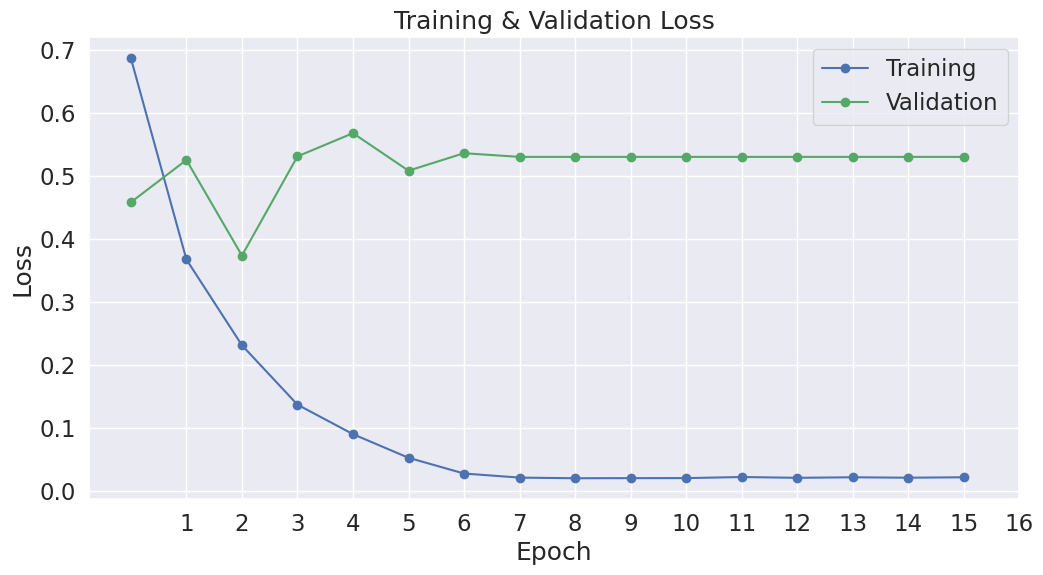

In [41]:
# Dibujar un diagrama con train loss vs validation loss. Si todo sale bien,
# validation loss debería descender y estabilizarse, aunque igual puede hacer overfitting.
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Usar el estilo de dibujos de seaborn
sns.set(style='darkgrid')

# Agradar el area de dibujo y el tamaño de letra
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# dibujar las curvas de aprendizaje
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Ponerle titulo
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1, EPOCHS+1)))

plt.show()

# Vemos las métricas en el dataset de validación (5% del dataset original)

Primero cargamos el mejor modelo que entrenamos en el fine-tunning, para eso lo cargamos en la variable model_dir.

In [11]:
from transformers import BertForSequenceClassification
from transformers import BertTokenizer

model_dir = '/Users/achain/Downloads/bert_finetuned_no_time_local'
print(f"Cargando modelo de clasificación BERT con finetuning desde el directorio: {model_dir}...")
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)
with open(model_dir+ '/'+ "label_texts.txt", "rt") as f:
  label_texts = f.read().split('\n')
print(f"Modelo BERT en {model_dir} cargado.")

if is_gpu:
   # copiar al modelo desde CPU a GPU
    model.to(device)

Cargando modelo de clasificación BERT con finetuning desde el directorio: /Users/achain/Downloads/bert_finetuned_no_time_local...
Modelo BERT en /Users/achain/Downloads/bert_finetuned_no_time_local cargado.


In [12]:
# URL del dataset en Github
zip_file_url = 'https://github.com/alechain/bert_classification_new/raw/main/articles_df_final.parquet.zip'

# Descargamos el ZIP
response = requests.get(zip_file_url)

# chequeamos si se descargo bien (status code 200)
if response.status_code == 200:
    # Read the content of the zip file
    with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_file:
        # Assume there's only one file in the zip, you may need to modify accordingly
        file_name = zip_file.namelist()[0]

        # Read the parquet file using pandas
        with zip_file.open(file_name) as parquet_file:
            my_dataset = pd.read_parquet(BytesIO(parquet_file.read()))
else:
    print(f"Failed to download the file. Status code: {response.status_code}")
    
#Filtramos posibles errores en articulos con longitud muy pequeña:
my_dataset=my_dataset[[len(i)>=200 for i in my_dataset.sentence]].reset_index(drop=True)

val=0.05
seed=30

val_dataset=my_dataset.iloc[np.random.permutation(len(my_dataset))].sample(frac=val,random_state=seed)
my_dataset=my_dataset[~my_dataset.index.isin(val_dataset.index)].reset_index(drop=True)
val_dataset=val_dataset.reset_index(drop=True)

label                                           sentence        date
0      socie  > En las efemérides del 18 de marzo sobresalen...  2023-03-18
1     el-pai  > La elección del Papa Francisco de un obispo ...  2023-05-29
2     el-pai  > Una fuerte ofensiva se cocina en los tribuna...  2023-03-17
3     el-pai  > El gobierno se prepara para la recta final d...  2023-08-07
4     el-pai  > "Ella siempre vivió conmigo, pero a partir d...  2023-08-29
...      ...                                                ...         ...
1048   socie  > El director de la comunidad terapéutica "La ...  2022-09-23
1049  el-mun  > Andrés Manuel López Obrador , AMLO, el presi...  2023-03-20
1050  el-pai  > El sacerdote Francisco "Paco" Olveira, integ...  2023-03-25
1051     eco  > El Gobierno nacional pondrá en marcha este l...  2023-04-10
1052   socie  > La voz se entrecorta. El llanto ahoga las pa...  2023-09-16

[1053 rows x 3 columns]

In [13]:
test_sentences=val_dataset.iloc[:,1].to_list()


In [14]:
test_sentences

['> En las efemérides del 18 de marzo sobresalen estos hechos que ocurrieron un día como hoy en la Argentina y el mundo: 1844. Nace Rimsky-Korsakov Nace Nikolai Rimsky-Korsakov, uno de los grandes compositores rusos . Maestro de la orquesta, dejó obras como la Obertura de la Gran Pascua Rusa , el Capricho Español y Scheherezade . Entre sus óperas destacan El gallo de oro y El Zar Saltán . Fue maestro de músicos como Igor Stravinsky y Ottorino Respighi. Murió en 1908 . 1938. México nacionaliza el petróleo El presidente mexicano Lázaro Cárdenas firma el decreto por el cual se expropian los trusts petroleros de origen extranjero . De esta forma, queda nacionalizada la producción petrolera. Cárdenas aplica el artículo 27 de las Constitución de México de 1917 y una ley de expropiación de 1936, que afecta a empresas de Estados Unidos, Gran Bretaña y Holanda. Nace Pemex, la compañía petrolera estatal . 1962. Elecciones y anulación Elecciones a gobernador en la Argentina . Se levanta de forma 

In [15]:
result_model=[]
MY_DATASET_MAX_TOKENS=512

for sent in test_sentences:
    # `encode_plus` DEBE SIEMPRE usar los mismos parametros usados durante fine tuning
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Frase a codificar.
                        add_special_tokens = True, # Agregar '[CLS]' y '[SEP]'
                        max_length = MY_DATASET_MAX_TOKENS,  # Llenar con el token PAD a frases cortas, o truncar frases mas  largas que MAX_TOKENS
                        padding='max_length',
                        truncation=True,
                        return_token_type_ids=True,
                        return_attention_mask = True,   # Construir las attn. masks.
                        return_tensors = 'pt',     # retornar pytorch tensors.
                   )
    encoded_dict.to(device)

    output = model(**encoded_dict)
    result_model.append(label_texts[output.logits.argmax(dim=1).item()])
    

In [16]:
result_model=pd.Series(result_model,name='model_result')
val_dataset['model_result']=result_model

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming df is your DataFrame
ground_truth = val_dataset['label']
predictions = val_dataset['model_result']


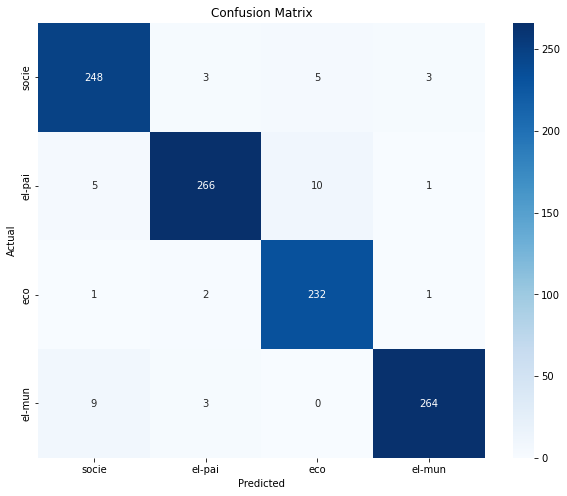


Classification Report:
              precision    recall  f1-score   support

         eco       0.94      0.98      0.96       236
      el-mun       0.98      0.96      0.97       276
      el-pai       0.97      0.94      0.96       282
       socie       0.94      0.96      0.95       259

    accuracy                           0.96      1053
   macro avg       0.96      0.96      0.96      1053
weighted avg       0.96      0.96      0.96      1053



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from io import StringIO


# Create a confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions, labels=val_dataset['label'].unique())

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset['label'].unique(), yticklabels=val_dataset['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display the classification report
class_report = classification_report(ground_truth, predictions)
print("\nClassification Report:")
print(class_report)